In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from utils import GluonConfigs

In [2]:
tf = GluonConfigs.load_data()

In [3]:
tf = tf.set_index('transect_id')
tf = tf.dropna(thresh=33)
print(f"Transects included in dataset: {tf.shape[0]}; timesteps: {tf.shape[1]}")
tf.head()

Transects included in dataset: 37111; timesteps: 33


,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
transect_id,,,,,,,,,,,,,,,,,,,,,
BOX_051_151_15,677.32043,695.66370,713.29486,682.1743,688.23425,672.13007,700.43286,693.43460,699.38560,687.97950,...,700.6640,712.41740,708.45123,740.33240,680.42510,758.35150,754.49695,763.04297,743.29680,779.41570
BOX_051_151_18,768.93800,769.23883,762.44300,755.8622,761.79663,760.51710,763.30505,761.81360,769.22100,765.47060,...,763.1057,759.72600,766.23150,770.77130,798.26830,797.99615,803.90950,797.90780,798.18830,803.68256
BOX_051_151_21,711.41626,684.20540,695.49817,701.6695,705.29990,703.61470,707.69403,692.90360,704.68280,704.99945,...,825.8698,820.51720,820.68680,842.18097,850.45460,775.96700,883.04240,867.92426,877.37415,874.50244
BOX_051_151_30,795.81573,820.63700,799.72380,799.8664,823.56260,822.07300,823.56800,823.73300,824.58400,824.33360,...,823.7820,823.15674,823.65790,821.31860,818.85803,817.31220,822.92970,818.73350,822.18480,818.73480
BOX_051_151_32,242.70204,238.05159,229.93718,244.0620,247.68105,257.49900,302.69217,301.27722,301.12033,316.40414,...,301.1231,313.63553,313.09814,312.90347,306.18658,294.18326,297.23654,302.88650,323.85840,304.36823


In [4]:
# tf = tf.sample(1000)

In [5]:
sites = pd.read_pickle("/media/storage/data/shorelines/sites-gluonts-prepared.pkl")
sites = sites.loc[sites['transect_id'].isin(tf.index)]
sites['coastline_idint'] = sites['coastline_idint'].astype(int)

In [6]:
def get_timestamp_first_obs(series: pd.Series) -> pd.Timestamp:
  yr = series.first_valid_index()
  return pd.Timestamp(f"01-01-{yr}", freq='1Y')

metadata = {'num_series': len(tf),
            'num_steps': len(tf.columns),
            'prediction_length': 7,
            'freq': "AS",
            'start': [pd.Timestamp("01-01-1984", freq='AS') for _ in range(len(tf))],
            'item_id': tf.index.values,
            'context_length': 7
            }

In [7]:
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset

train_ds = ListDataset(
    [
     {
         FieldName.TARGET: target,
         FieldName.START: start,
         FieldName.ITEM_ID: item_id,
         FieldName.FEAT_STATIC_CAT: [fsc],
         FieldName.FEAT_STATIC_REAL: [fsr]
      }
     
     for (target, start, item_id, fsc, fsr) in zip(tf.values[:, :-metadata['prediction_length']],
                                        metadata['start'], 
                                        metadata['item_id'],
                                        sites['coastline_idint'].values,
                                        sites['changerate_unc'].values)
    ], freq=metadata['freq'])

test_ds = ListDataset(
    [
     {
         FieldName.TARGET: target,
         FieldName.START: start,
         FieldName.ITEM_ID: item_id,
         FieldName.FEAT_STATIC_CAT: [fsc],
         FieldName.FEAT_STATIC_REAL: [fsr]
      }
     
     for (target, start, item_id, fsc, fsr) in zip(tf.values,
                                        metadata['start'], 
                                        metadata['item_id'],
                                        sites['coastline_idint'].values,
                                        sites['changerate_unc'].values)
    ], freq=metadata['freq'])

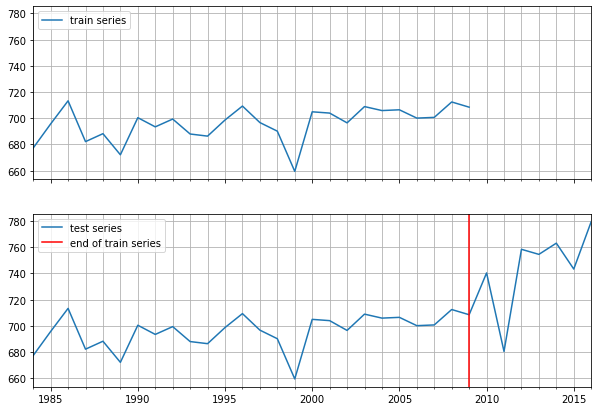

In [8]:
from gluonts.dataset.util import to_pandas


train_entry = next(iter(train_ds))
train_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

In [9]:
import pprint
from functools import partial


from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.seq2seq import MQCNNEstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

import project_path
from utils import get_predictor_id


epochs = 10
num_batches_per_epoch = 100
count = 0

estimators = [
    partial(
        SimpleFeedForwardEstimator,
        freq=metadata["freq"],
        trainer=Trainer(
            epochs=epochs, num_batches_per_epoch=num_batches_per_epoch
        ),
    ),
    partial(
        DeepAREstimator,
        freq="12M",
        use_feat_static_real=True,
        use_feat_static_cat=True,
        cardinality=[len(sites['coastline_idint'].unique())],
        trainer=Trainer(
            epochs=epochs, num_batches_per_epoch=num_batches_per_epoch
        ),
    ),
    partial(
        DeepAREstimator,
        freq="12M",
        use_feat_static_real=True,
        use_feat_static_cat=True,
        cardinality=[len(sites['coastline_idint'].unique())],
        distr_output=PiecewiseLinearOutput(8),
        trainer=Trainer(
            epochs=epochs, num_batches_per_epoch=num_batches_per_epoch
        ),
    ),
    partial(
        MQCNNEstimator,
        freq=metadata["freq"],
        trainer=Trainer(
            epochs=epochs, num_batches_per_epoch=num_batches_per_epoch
        ),
    ),
]

def evaluate(estimator):
    estimator = estimator(
        prediction_length=metadata['prediction_length'],
        context_length=metadata['context_length'],

        

    )

    print(f"evaluating {estimator}")

    predictor = estimator.train(train_ds)

    forecast_it, ts_it = make_evaluation_predictions(
        test_ds, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(test_ds)
    )
    
    item_metrics["prediction_length"] = metadata["prediction_length"]
    item_metrics["context_length"] = metadata["context_length"]
    item_metrics["predictor_id"] = get_predictor_id()
    item_metrics["predictor"] = type(estimator).__name__
    agg_metrics["predictor_id"] = get_predictor_id()
    agg_metrics["predictor"] = type(estimator).__name__
    
    return item_metrics, agg_metrics


# item_metrics_list = []
# agg_metrics_list = []
# for estimator in estimators:
#     count+=1
#     # catch exceptions that are happening during training to avoid failing the whole evaluation
#     try:
#         item_metrics, agg_metrics = evaluate(estimator)

#         item_metrics_list.append(item_metrics)
#         agg_metrics_list.append(agg_metrics)

#     except Exception as e:
#         print(f"\n---> ---> ---> --->\nException error:\n")
#         print(str(e))
#         print("\n<--- <--- <--- <---\n")

        
        
        
        


In [10]:
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions


def evaluate_r_methods(method_names: list, dataset) -> pd.DataFrame:
    results = []
    for method in method_names:
        predictor = RForecastPredictor(
            freq=metadata['freq'],  
            prediction_length=metadata['prediction_length'],
            method_name = method
            )
      
        forecast_it, ts_it = make_evaluation_predictions(
            dataset, predictor=predictor, num_samples=100
        )        

        
        evaluator = Evaluator()

        agg_metrics, item_metrics = evaluator(ts_it, forecast_it)
        
        item_metrics["prediction_length"] = metadata["prediction_length"]
        item_metrics["context_length"] = metadata["context_length"]
        item_metrics["predictor"] = method
        item_metrics["predictor_id"] = get_predictor_id()
        item_metrics["item_id"] = [i["item_id"] for i in iter(dataset)]
        results.append(item_metrics)
    return pd.concat(results)

# metrics = evaluate_r_methods(["ets", "arima"], test_ds)

In [11]:
metadata = {'num_series': len(tf),
            'num_steps': len(tf.columns),
            'prediction_length': 7,
            'freq': "AS",
            'start': [pd.Timestamp("01-01-1984", freq='AS') for _ in range(len(tf))],
            'item_id': tf.index.values,
            'context_length': 7
            }


results = []
for i in np.arange(1, 28, 3):
    metadata['prediction_length'] = i
    metadata['context_length'] = len(tf.columns) - metadata['prediction_length']

    
    item_metrics_list = []
    agg_metrics_list = []
    for estimator in estimators:
        count+=1
        # catch exceptions that are happening during training to avoid failing the whole evaluation
        try:
            item_metrics, agg_metrics = evaluate(estimator)

            item_metrics_list.append(item_metrics)
            agg_metrics_list.append(agg_metrics)

        except Exception as e:
            print(f"\n---> ---> ---> --->\nException error:\n")
            print(str(e))
            print("\n<--- <--- <--- <---\n")
    
    dl_metrics = pd.concat(item_metrics_list)
    
    r_metrics = evaluate_r_methods(["ets", "arima"], test_ds)
    
    metrics = pd.concat([dl_metrics, r_metrics])
    results.append(metrics)
    

  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.simple_feedforward._estimator.SimpleFeedForwardEstimator(batch_normalization=False, context_length=32, distr_output=gluonts.distribution.student_t.StudentTOutput(), freq="AS", mean_scaling=True, num_hidden_dimensions=None, num_parallel_samples=100, prediction_length=1, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08))
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.deepar._estimator.DeepAREstimator(cardinality=[1387], cell_type="lstm", context_length=32, distr_output=gluonts.distribution.student_t.StudentTOutput(), dropout_rate=0.1, embedding_dimension=None, freq="12M", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, prediction_length=1, scaling=True, time_features=None, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=True, use_feat_static_real=True)
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.deepar._estimator.DeepAREstimator(cardinality=[1387], cell_type="lstm", context_length=32, distr_output=gluonts.distribution.piecewise_linear.PiecewiseLinearOutput(num_pieces=8), dropout_rate=0.1, embedding_dimension=None, freq="12M", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, prediction_length=1, scaling=True, time_features=None, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=True, use_feat_static_real=True)
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.seq2seq._mq_dnn_estimator.MQCNNEstimator(context_length=32, freq="AS", mlp_final_dim=20, mlp_hidden_dimension_seq=[], prediction_length=1, quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08))
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 37111/37111 [00:56<00:00, 651.74it/s]
/media/storage/dev/shorelineforecasting/shorelineforecasting/venv/lib/python3.8/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)
Running evaluation: 37111it [12:40, 48.83it/s]
Running evaluation: 37111it [1:13:26,  8.42it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.simple_feedforward._estimator.SimpleFeedForwardEstimator(batch_normalization=False, context_length=29, distr_output=gluonts.distribution.student_t.StudentTOutput(), freq="AS", mean_scaling=True, num_hidden_dimensions=None, num_parallel_samples=100, prediction_length=4, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08))
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.deepar._estimator.DeepAREstimator(cardinality=[1387], cell_type="lstm", context_length=29, distr_output=gluonts.distribution.student_t.StudentTOutput(), dropout_rate=0.1, embedding_dimension=None, freq="12M", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, prediction_length=4, scaling=True, time_features=None, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=True, use_feat_static_real=True)
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.deepar._estimator.DeepAREstimator(cardinality=[1387], cell_type="lstm", context_length=29, distr_output=gluonts.distribution.piecewise_linear.PiecewiseLinearOutput(num_pieces=8), dropout_rate=0.1, embedding_dimension=None, freq="12M", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, prediction_length=4, scaling=True, time_features=None, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=True, use_feat_static_real=True)
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.seq2seq._mq_dnn_estimator.MQCNNEstimator(context_length=29, freq="AS", mlp_final_dim=20, mlp_hidden_dimension_seq=[], prediction_length=4, quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08))
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 37111/37111 [00:57<00:00, 642.50it/s]
Running evaluation: 37111it [12:33, 49.25it/s]
Running evaluation: 37111it [1:12:22,  8.55it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.simple_feedforward._estimator.SimpleFeedForwardEstimator(batch_normalization=False, context_length=26, distr_output=gluonts.distribution.student_t.StudentTOutput(), freq="AS", mean_scaling=True, num_hidden_dimensions=None, num_parallel_samples=100, prediction_length=7, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08))
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.deepar._estimator.DeepAREstimator(cardinality=[1387], cell_type="lstm", context_length=26, distr_output=gluonts.distribution.student_t.StudentTOutput(), dropout_rate=0.1, embedding_dimension=None, freq="12M", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, prediction_length=7, scaling=True, time_features=None, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=True, use_feat_static_real=True)
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.deepar._estimator.DeepAREstimator(cardinality=[1387], cell_type="lstm", context_length=26, distr_output=gluonts.distribution.piecewise_linear.PiecewiseLinearOutput(num_pieces=8), dropout_rate=0.1, embedding_dimension=None, freq="12M", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, prediction_length=7, scaling=True, time_features=None, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=True, use_feat_static_real=True)
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.seq2seq._mq_dnn_estimator.MQCNNEstimator(context_length=26, freq="AS", mlp_final_dim=20, mlp_hidden_dimension_seq=[], prediction_length=7, quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08))
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 37111/37111 [01:02<00:00, 592.30it/s]
Running evaluation: 37111it [14:08, 43.73it/s]
Running evaluation: 37111it [1:15:56,  8.14it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.simple_feedforward._estimator.SimpleFeedForwardEstimator(batch_normalization=False, context_length=23, distr_output=gluonts.distribution.student_t.StudentTOutput(), freq="AS", mean_scaling=True, num_hidden_dimensions=None, num_parallel_samples=100, prediction_length=10, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08))
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.deepar._estimator.DeepAREstimator(cardinality=[1387], cell_type="lstm", context_length=23, distr_output=gluonts.distribution.student_t.StudentTOutput(), dropout_rate=0.1, embedding_dimension=None, freq="12M", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, prediction_length=10, scaling=True, time_features=None, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=True, use_feat_static_real=True)
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.deepar._estimator.DeepAREstimator(cardinality=[1387], cell_type="lstm", context_length=23, distr_output=gluonts.distribution.piecewise_linear.PiecewiseLinearOutput(num_pieces=8), dropout_rate=0.1, embedding_dimension=None, freq="12M", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, prediction_length=10, scaling=True, time_features=None, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=True, use_feat_static_real=True)
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

evaluating gluonts.model.seq2seq._mq_dnn_estimator.MQCNNEstimator(context_length=23, freq="AS", mlp_final_dim=20, mlp_hidden_dimension_seq=[], prediction_length=10, quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=10, weight_decay=1e-08))
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 37111/37111 [00:58<00:00, 638.02it/s]
Running evaluation: 37111it [14:38, 42.24it/s]
Running evaluation: 37111it [1:14:49,  8.27it/s]
Running evaluation: 100%|██████████| 37111/37111 [01:04<00:00, 573.83it/s]
Running evaluation: 37111it [14:02, 44.03it/s]
Running evaluation: 37111it [1:09:25,  8.91it/s]
Running evaluation:  40%|████      | 14982/37111 [04:47<07:52, 46.83it/s]Process ForkPoolWorker-125:
Process ForkPoolWorker-128:
Process ForkPoolWorker-127:
Process ForkPoolWorker-126:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3

In [ ]:
pd.concat(results).to_pickle("/media/storage/data/shorelines/supermetrics.pkl")